In [1]:
# Import the modules
import cv2
from sklearn.externals import joblib
from skimage.feature import hog
import numpy as np
import pickle

import imageio
import numpy as np
from matplotlib import pyplot as plt

from keras.models import load_model

/Users/alimali/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
model = load_model("fitted_model.h5")

In [17]:
im = imageio.imread("data/example5.jpg")

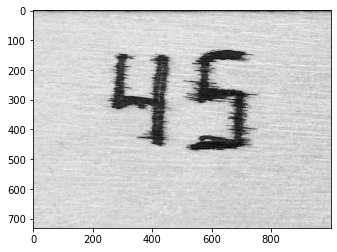

In [18]:
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = plt.get_cmap('gray'))
plt.show()

### Segmentation

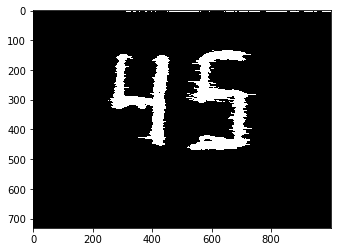

In [19]:
# Threshold the image
ret, im_th = cv2.threshold(gray, 110, 255, cv2.THRESH_BINARY_INV)

plt.imshow(im_th, cmap = plt.get_cmap('gray'))
plt.show()

In [20]:
def rectsfilter(segm):
    maxvol = 0
    volumes = []
    for s in segm:
        volume = s[2] * s[3]
        volumes.append(volume)
        if maxvol < volume:
            maxvol = volume
            
    rezsegm = []
    for i in range(len(segm)):
        if volumes[i] < maxvol * 0.5:
            continue
        rezsegm.append(segm[i])
    return rezsegm

In [21]:
# Find contours in the image
contours, hierarchy = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [22]:
rects = [cv2.boundingRect(ctr) for ctr in contours]
rects = rectsfilter(rects)
rects.sort(key=lambda x: x[0])
rects

[(256, 146, 204, 310), (511, 133, 239, 339)]

In [23]:
digits = []
for rect in rects:
    # Draw the rectangles
    cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3) 
    
    # Make the rectangular region around the digit
    leng = int(rect[3] * 1.3)
    roi = im_th[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
    roi = cv2.copyMakeBorder(roi, 12, 12, 45, 45, cv2.BORDER_CONSTANT)
    
    # Resize the image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)

    # Calculate the HOG features
    roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1))
    nbr = model.predict_proba(np.array(roi[np.newaxis,:, :, np.newaxis], 'float64'))
    nbr = np.argmax(nbr)
    
    cv2.putText(im, str(int(nbr)), (rect[0], rect[1]),cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 3)
    
    digits.append(str(nbr))

print('Result:', ''.join(digits))


Result: 45


In [ ]:
# drawing..

cv2.imshow("Resulting Image with Rectangular ROIs", im)
cv2.waitKey()